<a href="https://colab.research.google.com/github/rjsgk5792/AI_12th_project/blob/main/%EC%9E%90%EB%8F%99%EC%B0%A8_%EC%A0%9C%EC%A1%B0_%ED%85%8C%EC%8A%A4%ED%8A%B8_%EA%B3%B5%EC%A0%95_%EC%8B%9C%EA%B0%84_%EC%98%88%EC%B8%A1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [126]:
# matplotlib 한글 깨짐 현상 해결

# !apt-get update -qq
# !apt-get install fonts-nanum* -qq

# import matplotlib.font_manager as fm
# from matplotlib import pyplot as plt

# path = '/usr/share/fonts/truetype/nanum/NanumGothicEco.ttf'
# font_name = fm.FontProperties(fname=path,size=10).get_name()

# plt.rc('font',family=font_name)

# fm._rebuild()

In [127]:
import matplotlib.pyplot as plt
plt.rc('font', family = 'NanumBarunGothic')

# 01. 데이터 소개 및 분석프로세스 수립

# 02. 데이터 준비를 위한 EDA 및 전처리

### 0.데이터 불러오기

In [128]:
import numpy as np
import pandas as pd
import seaborn as sns

from itertools import combinations

from sklearn import preprocessing
import xgboost as xgb

from sklearn.preprocessing import LabelEncoder

# 차원 축소 기법
from sklearn.decomposition import PCA


from sklearn.ensemble import RandomForestRegressor


# 모델, 모델평가
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.pipeline import make_pipeline, make_union
from sklearn.utils import check_array
from sklearn.metrics import r2_score

from sklearn.model_selection import cross_val_score, KFold, train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.feature_selection import SelectFromModel

seed = 40

import warnings
warnings.filterwarnings('ignore')
color = sns.color_palette()
%matplotlib inline

In [129]:
train_df = pd.read_csv('/content/drive/MyDrive/부트캠프/Section2 Project/train.csv')
test_df = pd.read_csv('/content/drive/MyDrive/부트캠프/Section2 Project/test.csv')
print('Train shape' , train_df.shape)
print('Test shape' , test_df.shape)

Train shape (4209, 378)
Test shape (4209, 377)


In [130]:
train_df.head()


,ID,y,X0,X1,X2,X3,X4,X5,X6,X8,...,X375,X376,X377,X378,X379,X380,X382,X383,X384,X385
0,0,130.81,k,v,at,a,d,u,j,o,...,0,0,1,0,0,0,0,0,0,0
1,6,88.53,k,t,av,e,d,y,l,o,...,1,0,0,0,0,0,0,0,0,0
2,7,76.26,az,w,n,c,d,x,j,x,...,0,0,0,0,0,0,1,0,0,0
3,9,80.62,az,t,n,f,d,x,l,e,...,0,0,0,0,0,0,0,0,0,0
4,13,78.02,az,v,n,f,d,h,d,n,...,0,0,0,0,0,0,0,0,0,0



* ID : 테스트 번호
* y: 자동차 제조 테스트 공정 시간
* X0~X8 : 범주형 Feature
* X10~X385 : 숫자형 Feature
* target : 시간 예측


### Target Feature

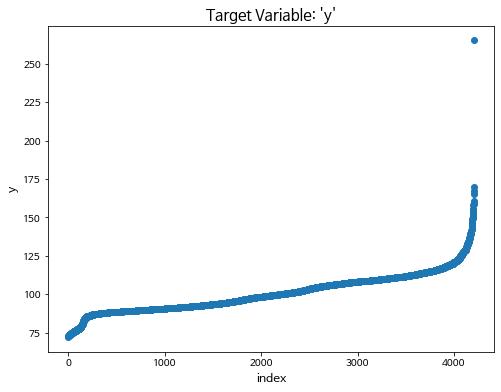

In [131]:
# scatter plot

plt.figure(figsize=(8,6))
plt.scatter(range(train_df.shape[0]),np.sort(train_df.y.values))
plt.xlabel('index',fontsize=12)
plt.ylabel('y',fontsize=12)
plt.title("Target Variable: 'y'",fontsize=15)
plt.show()

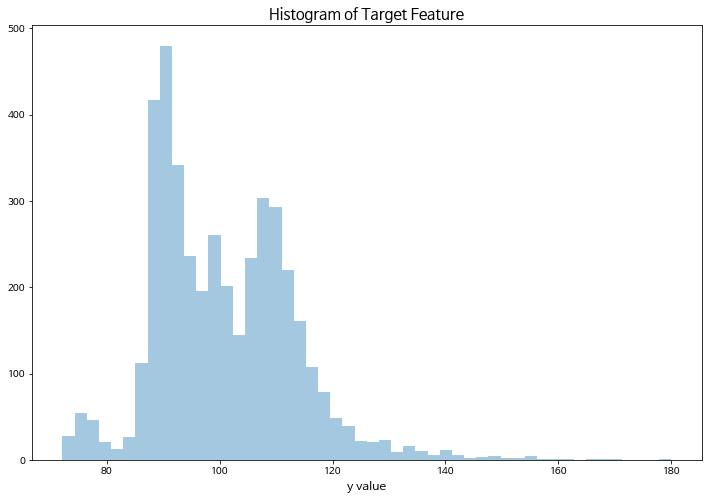

In [132]:
# 이상치 처리

ulimit = 180
train_df['y'].loc[train_df['y'] > ulimit] = ulimit

plt.figure(figsize=(12,8))
sns.distplot(train_df.y.values, bins=50, kde=False)
plt.xlabel('y value',fontsize=12)
plt.title('Histogram of Target Feature',fontsize=15)
plt.show()

In [133]:
print('180보다 큰 숫자들 개수: {}'.format(np.sum(train_df['y'].values > 180)))

180보다 큰 숫자들 개수: 0


In [134]:
# 최소, 최대, 평균, 표준편차 값 보기

train_df.describe()['y']

count    4209.000000
mean      100.649047
std        12.482765
min        72.110000
25%        90.820000
50%        99.150000
75%       109.010000
max       180.000000
Name: y, dtype: float64

### 데이터 탐색

In [135]:
dtype_df = train_df.dtypes.reset_index()
dtype_df.columns = ['Count','Column Type']
dtype_df.groupby('Column Type').aggregate('count').reset_index()

,Column Type,Count
0,int64,369
1,float64,1
2,object,8


In [136]:
dtype_df.loc[:10,:]

,Count,Column Type
0,ID,int64
1,y,float64
2,X0,object
3,X1,object
4,X2,object
5,X3,object
6,X4,object
7,X5,object
8,X6,object
9,X8,object


#### 결측값

In [137]:
missing_df = train_df.isnull().sum(axis=0).reset_index()
missing_df.columns = ['column_name','missing_count']
missing_df = missing_df.loc[missing_df['missing_count']>0]
missing_df = missing_df.sort_values(by='missing_count')
missing_df

,column_name,missing_count


In [138]:
cols = [c for c in train_df.columns if 'X' in c]   # X 가 들어간 Feature
print('Number of features: {}'.format(len(cols)))
print('Feature types:')
train_df[cols].dtypes.value_counts()

Number of features: 376
Feature types:


int64     368
object      8
dtype: int64

In [139]:
counts = [ [], [], [] ]
for c in cols:
  typ = train_df[c].dtype
  uniq = len(np.unique(train_df[c]))
  if uniq ==1: counts[0].append(c)   # Feature 값 1개
  elif uniq == 2 and typ == np.int64 : counts[1].append(c)   # Feature 값 2개
  else: counts[2].append(c)     # 범주형

print('Feature 값이 1개인 경우 : {} Feature 값이 2개인 경우: {} 범주형 Feature인 경우 : {} \n'.format(*[len(c) for c in counts]))

print('Feature 값이 1개인 경우 : ',counts[0])
print('Feature 값이 2개인 경우:', counts[2])

Feature 값이 1개인 경우 : 12 Feature 값이 2개인 경우: 356 범주형 Feature인 경우 : 8 

Feature 값이 1개인 경우 :  ['X11', 'X93', 'X107', 'X233', 'X235', 'X268', 'X289', 'X290', 'X293', 'X297', 'X330', 'X347']
Feature 값이 2개인 경우: ['X0', 'X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X8']


In [140]:
unique_values_dict = {}
for col in train_df.columns:
  if col not in ['ID','y','X0','X1','X2','X3','X4','X5','X6','X8']:
    unique_value = str(np.sort(train_df[col].unique()).tolist())
    tlist = unique_values_dict.get(unique_value,[])
    tlist.append(col)
    unique_values_dict[unique_value] = tlist[:]

for unique_val, columns in unique_values_dict.items():
  print('컬럼에 존재하는 유일한 값들: ',unique_val)
  print(columns)

컬럼에 존재하는 유일한 값들:  [0, 1]
['X10', 'X12', 'X13', 'X14', 'X15', 'X16', 'X17', 'X18', 'X19', 'X20', 'X21', 'X22', 'X23', 'X24', 'X26', 'X27', 'X28', 'X29', 'X30', 'X31', 'X32', 'X33', 'X34', 'X35', 'X36', 'X37', 'X38', 'X39', 'X40', 'X41', 'X42', 'X43', 'X44', 'X45', 'X46', 'X47', 'X48', 'X49', 'X50', 'X51', 'X52', 'X53', 'X54', 'X55', 'X56', 'X57', 'X58', 'X59', 'X60', 'X61', 'X62', 'X63', 'X64', 'X65', 'X66', 'X67', 'X68', 'X69', 'X70', 'X71', 'X73', 'X74', 'X75', 'X76', 'X77', 'X78', 'X79', 'X80', 'X81', 'X82', 'X83', 'X84', 'X85', 'X86', 'X87', 'X88', 'X89', 'X90', 'X91', 'X92', 'X94', 'X95', 'X96', 'X97', 'X98', 'X99', 'X100', 'X101', 'X102', 'X103', 'X104', 'X105', 'X106', 'X108', 'X109', 'X110', 'X111', 'X112', 'X113', 'X114', 'X115', 'X116', 'X117', 'X118', 'X119', 'X120', 'X122', 'X123', 'X124', 'X125', 'X126', 'X127', 'X128', 'X129', 'X130', 'X131', 'X132', 'X133', 'X134', 'X135', 'X136', 'X137', 'X138', 'X139', 'X140', 'X141', 'X142', 'X143', 'X144', 'X145', 'X146', 'X147', 'X14

#### 범주형 Features

In [141]:
cat_feat = counts[2]
train_df[cat_feat].head()

,X0,X1,X2,X3,X4,X5,X6,X8
0,k,v,at,a,d,u,j,o
1,k,t,av,e,d,y,l,o
2,az,w,n,c,d,x,j,x
3,az,t,n,f,d,x,l,e
4,az,v,n,f,d,h,d,n


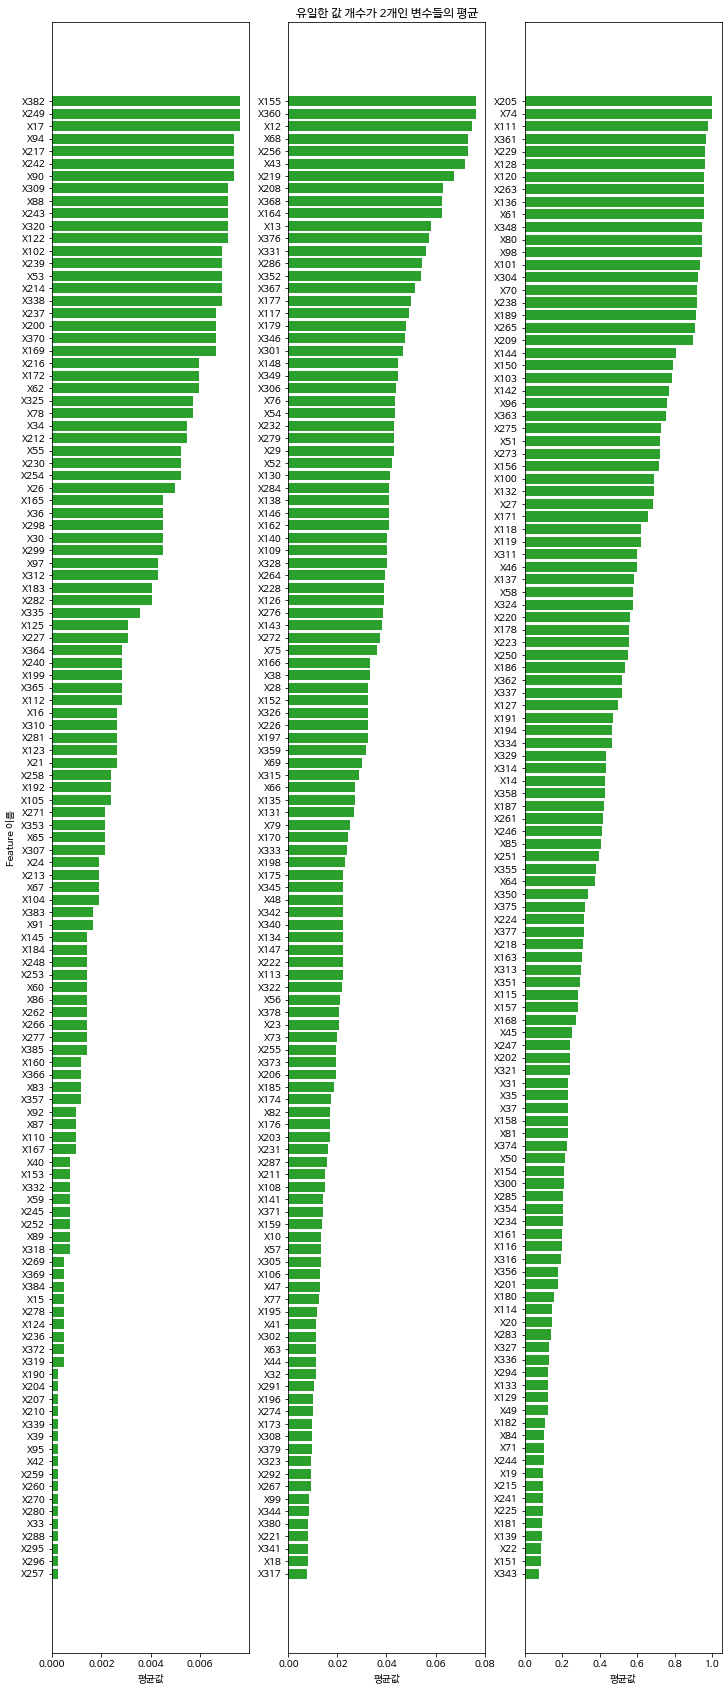

In [142]:
binary_means = [np.mean(train_df[c]) for c in counts[1]]
binary_names = np.array(counts[1])[np.argsort(binary_means)]
binary_means = np.sort(binary_means)

fig,ax = plt.subplots(1,3,figsize=(12,30))
ax[0].set_ylabel('Feature 이름')
ax[1].set_title('유일한 값 개수가 2개인 변수들의 평균')
for i in range(3):
  names,means = binary_names[i*119:(i+1)*119],binary_means[i*119:(i+1)*119]
  ax[i].barh(range(len(means)), means, color = color[2])
  ax[i].set_xlabel('평균값')
  ax[i].set_yticks(range(len(means)))
  ax[i].set_yticklabels(names,rotation='horizontal')
plt.show()

# 머신러닝 모델링

## Baseline Model 1: xgboost model 

### Label Encoding

In [143]:
for f in ['X0','X1','X2','X3','X4','X5','X6','X8']:
  encoder = preprocessing.LabelEncoder()
  encoder.fit(list(train_df[f].values))
  train_df[f] = encoder.transform(list(train_df[f].values))

### 데이터 준비

In [144]:
train_y = train_df['y'].values
train_X = train_df.drop(['ID','y'],axis=1)

### 모델 생성

In [145]:
def xgb_r2_score(preds,dtrain):
  labels = dtrain.get_label()
  return 'r2',r2_score(labels,preds)

xgb_params = {
    'eta':0.05,
    'max_depth':6,
    'subsample':0.7,
    'colsample_bytree':0.7,
    'objective':'reg:linear',
    'silent':1
}
dtrain = xgb.DMatrix(train_X,train_y,feature_names=train_X.columns.values)
model = xgb.train(dict(xgb_params,silent=0),dtrain,num_boost_round=100,feval=xgb_r2_score,maximize=True)


[08:15:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


### Feature Importances

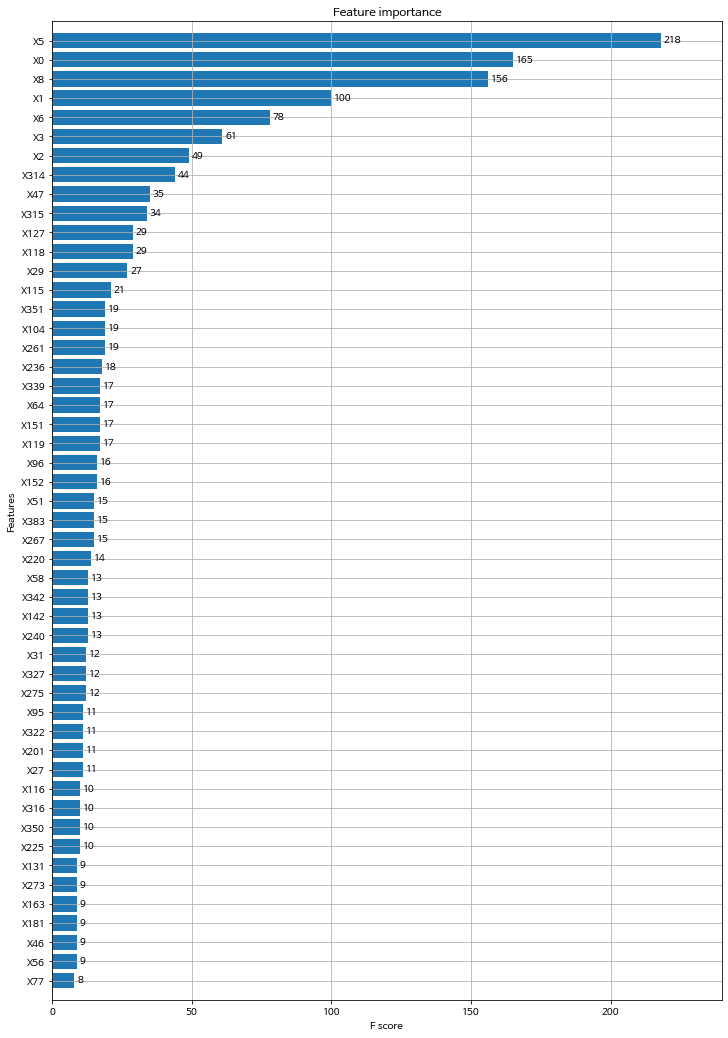

In [146]:
fig, ax = plt.subplots(figsize = (12,18))
xgb.plot_importance(model, max_num_features=50, height=0.8,ax=ax)
plt.show()

## Baseline Model 2: Random Forest Model

### 모델 생성

In [147]:
from sklearn import ensemble
model = ensemble.RandomForestRegressor(
    n_estimators=200,
    max_depth=10,
    min_samples_leaf=4,
    max_features=0.2,
    n_jobs=-1,
    random_state=0)

model.fit(train_X,train_y)

RandomForestRegressor(max_depth=10, max_features=0.2, min_samples_leaf=4,
                      n_estimators=200, n_jobs=-1, random_state=0)

### Feature Importances

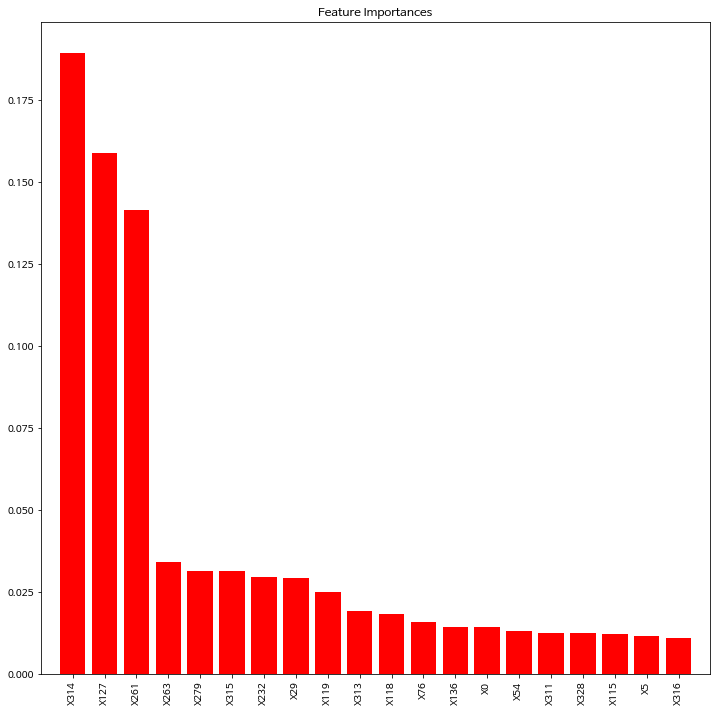

In [148]:
feat_names = train_X.columns.values
importances = model.feature_importances_
indices = np.argsort(importances)[::-1][:20]

plt.figure(figsize=(12,12))
plt.title("Feature Importances")
plt.bar(range(len(indices)),importances[indices],color='r',align='center')
plt.xticks(range(len(indices)),feat_names[indices],rotation='vertical')
plt.xlim([-1,len(indices)])
plt.show()

# 차원 축소 기법을 활용한 예측 모델링

## 일반적인 적용

### 데이터 준비

In [149]:
train = pd.read_csv('/content/drive/MyDrive/부트캠프/Section2 Project/train.csv')
test = pd.read_csv('/content/drive/MyDrive/부트캠프/Section2 Project/test.csv')

y_train = train['y']
train = train.drop('y',axis=1)

### Label Encoding

In [150]:
for c in train.columns:
  if train[c].dtype=='object':
    encoder = LabelEncoder()
    encoder.fit(list(train[c].values) + list(test[c].values))
    train[c] = encoder.transform(list(train[c].values))
    test[c] = encoder.transform(list(test[c].values))

### 차원 축소 방법 적용

In [151]:
n_comp = 8


pca = PCA(n_components=n_comp,random_state=420)
pca2_results_train = pca.fit_transform(train)
pca2_results_test = pca.transform(test)

y_mean = np.mean(y_train)

train_pca = pd.DataFrame()
test_pca = pd.DataFrame()

for i in range(1,n_comp+1):
  train_pca['pca_'+str(i)] = pca2_results_train[:, i-1]
  test_pca['pca_'+str(i)] = pca2_results_test[:, i-1]


In [152]:
# # xgboost 모델 적용
# xgb_params = {
#     'n_trees' : 500,
#     'eta':0.005,
#     'max_depth':5,
#     'subsample':0.9,
#     'objective':'reg:linear',
#     'eval_metric':'rmse',
#     'base_score': np.mean(y_train),
#     'silent':1
# }

# dtrain = xgb.DMatrix(train_pca,y_train)

# num_boost_rounds = 1250
# model = xgb.train(xgb_params, dtrain, num_boost_round=num_boost_rounds)

# r2_score = r2_score(y_train,model.predict(dtrain))

# print('train셋 score : ' ,r2_score)

In [153]:
xgb_params = {
    'n_trees' : 500,
    'eta':0.050,
    'max_depth':6,
    'subsample':0.5,
    'objective':'reg:linear',
    'eval_metric':'rmse',
    'base_score': y_mean,
    'silent':1
}
# xgboost 데이터 형태로 준비
dtrain=xgb.DMatrix(train_pca,y_train)
dtest = xgb.DMatrix(test_pca)

cv_result = xgb.cv(xgb_params,dtrain,num_boost_round=700,verbose_eval=50,show_stdv=False)

# xgboost, cv
num_boost_rounds = len(cv_result)
print(num_boost_rounds)

# fit
model = xgb.train(dict(xgb_params,silent=0),dtrain,num_boost_round=num_boost_rounds)

[0]	train-rmse:12.4665	test-rmse:12.4928
[50]	train-rmse:8.4733	test-rmse:10.1319
[100]	train-rmse:7.28828	test-rmse:10.0944
[150]	train-rmse:6.47667	test-rmse:10.0721
[200]	train-rmse:5.77324	test-rmse:10.0901
[250]	train-rmse:5.20807	test-rmse:10.1179
[300]	train-rmse:4.75086	test-rmse:10.1498
[350]	train-rmse:4.31737	test-rmse:10.1905
[400]	train-rmse:3.92183	test-rmse:10.2115
[450]	train-rmse:3.57466	test-rmse:10.2312
[500]	train-rmse:3.28149	test-rmse:10.2525
[550]	train-rmse:3.00473	test-rmse:10.2735
[600]	train-rmse:2.76497	test-rmse:10.3011
[650]	train-rmse:2.53873	test-rmse:10.3224
[699]	train-rmse:2.34842	test-rmse:10.3327
700
[08:15:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


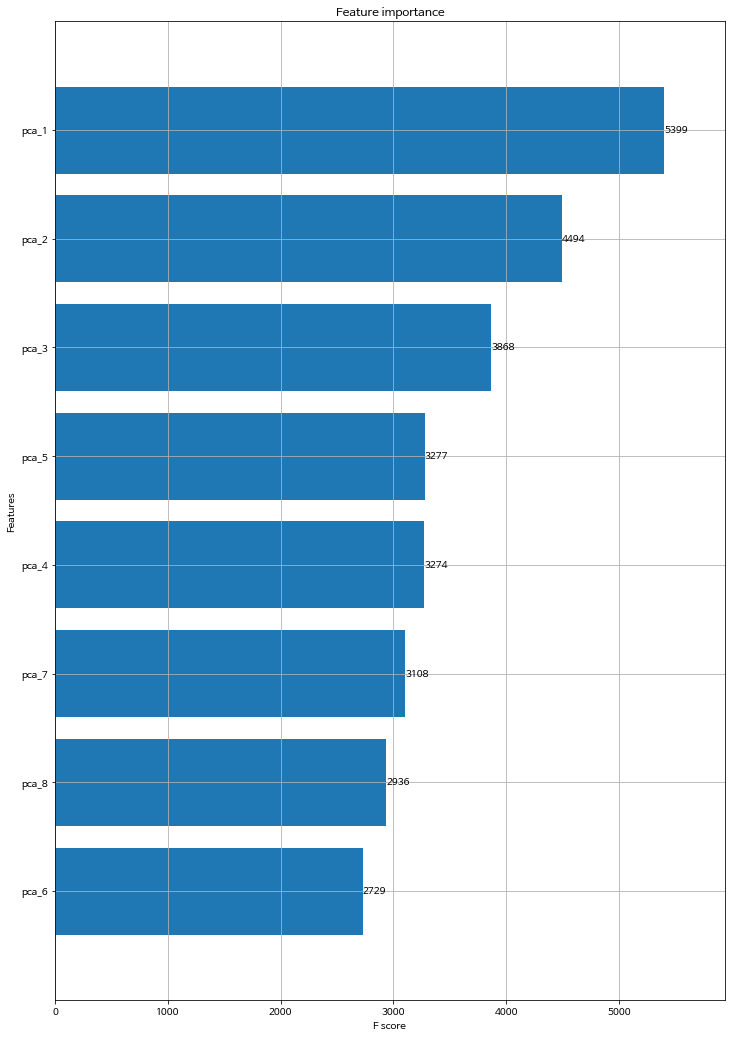

In [154]:
fig, ax = plt.subplots(figsize = (12,18))
xgb.plot_importance(model, max_num_features=50, height=0.8,ax=ax)
plt.show()

### 모델 성능 비교

In [155]:
from sklearn.metrics import r2_score
print(r2_score(dtrain.get_label(), model.predict(dtrain)))

0.9338605871657162


### Baseline

In [156]:
def xgb_r2_score(preds,dtrain):
  labels = dtrain.get_label()
  return 'r2',r2_score(labels,preds)

xgb_params = {
    'eta':0.05,
    'max_depth':6,
    'subsample':0.7,
    'colsample_bytree':0.7,
    'objective':'reg:linear',
    'silent':1
}
dtrain_base = xgb.DMatrix(train_X,train_y,feature_names=train_X.columns.values)
model = xgb.train(dict(xgb_params,silent=0),dtrain_base,num_boost_round=100,feval=xgb_r2_score,maximize=True)

print(r2_score(dtrain_base.get_label(), model.predict(dtrain_base)))

[08:15:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
0.6576189513158743


In [157]:
from sklearn import ensemble
model = ensemble.RandomForestRegressor(
    n_estimators=200,
    max_depth=10,
    min_samples_leaf=4,
    max_features=0.2,
    n_jobs=-1,
    random_state=0)

model.fit(train_X,train_y)

print(r2_score(train_y,model.predict(train_X)))

0.6514962542482952


**위에서 적용한 차원 축소의 결과가 점수가 높은 것을 알 수 있다.**

## Regression model 적용

In [158]:
train = pd.read_csv('/content/drive/MyDrive/부트캠프/Section2 Project/train.csv')
test = pd.read_csv('/content/drive/MyDrive/부트캠프/Section2 Project/test.csv')

### Label Encoding

In [159]:
for c in train.columns:
  if train[c].dtype=='object':
    encoder = LabelEncoder()
    encoder.fit(list(train[c].values) + list(test[c].values))
    train[c] = encoder.transform(list(train[c].values))
    test[c] = encoder.transform(list(test[c].values))

### 데이터 준비

In [160]:
train_y = train['y'].values
y_mean = np.mean(train_y)
id_test = test['ID'].values
train = train.drop(['ID'],axis=1)
test = test.drop(['ID'],axis=1)

def xgb_r2_score(preds,dtrain):
  labels = dtrain.get_label()
  return 'r2', r2_score(labels,preds)

usable_columns = list(set(train.columns) - set(['y']))

In [161]:
final_train = train[usable_columns].values
final_test = test[usable_columns].values

xgb_params = {
    'n_trees' : 500,
    'eta':0.005,
    'max_depth':5,
    'subsample':0.9,
    'objective':'reg:linear',
    'eval_metric':'rmse',
    'base_score': y_mean,
    'silent':1
}
# xgboost 데이터 형태로 준비
dtrain=xgb.DMatrix(train.drop(['y'],axis=1),train_y)
dtest = xgb.DMatrix(test)

cv_result = xgb.cv(xgb_params,dtrain,num_boost_round=300,verbose_eval=50,show_stdv=False)

# xgboost, cv
num_boost_rounds = len(cv_result)
print(num_boost_rounds)


[0]	train-rmse:12.6401	test-rmse:12.6383
[50]	train-rmse:11.0844	test-rmse:11.1411
[100]	train-rmse:10.0025	test-rmse:10.1285
[150]	train-rmse:9.26279	test-rmse:9.46613
[200]	train-rmse:8.76351	test-rmse:9.0436
[250]	train-rmse:8.42797	test-rmse:8.78112
[299]	train-rmse:8.20431	test-rmse:8.6221
300


In [162]:
model = xgb.train(dict(xgb_params, silent=0), dtrain, num_boost_round=num_boost_rounds)
y_pred = model.predict(dtest)

[08:16:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [163]:
pipe = make_pipeline(
    GradientBoostingRegressor(learning_rate=0.001,loss='huber',max_features=0.55,
                              min_samples_leaf=18,
                              min_samples_split=14,subsample=0.7)
)
pipe.fit(final_train,train_y)
predictions = pipe.predict(final_test)

In [164]:
print('R2 score on train data:')
print(r2_score(train_y,pipe.predict(final_train)*0.25 + model.predict(dtrain)*0.75))

predicted=pd.DataFrame()
predicted['ID'] = id_test
predicted['y'] = y_pred*0.75 + predictions*0.25
predicted

R2 score on train data:
0.5036048206411069


,ID,y
0,1,86.402969
1,2,101.649368
2,3,87.110598
3,4,86.419271
4,5,107.138529
...,...,...
4204,8410,102.238967
4205,8411,96.975278
4206,8413,96.278094
4207,8414,106.621233


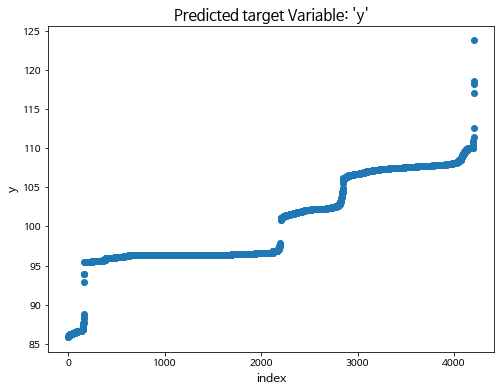

In [165]:
# scatter plot

plt.figure(figsize=(8,6))
plt.scatter(range(predicted.shape[0]),np.sort(predicted.y.values))
plt.xlabel('index',fontsize=12)
plt.ylabel('y',fontsize=12)
plt.title("Predicted target Variable: 'y'",fontsize=15)
plt.show()

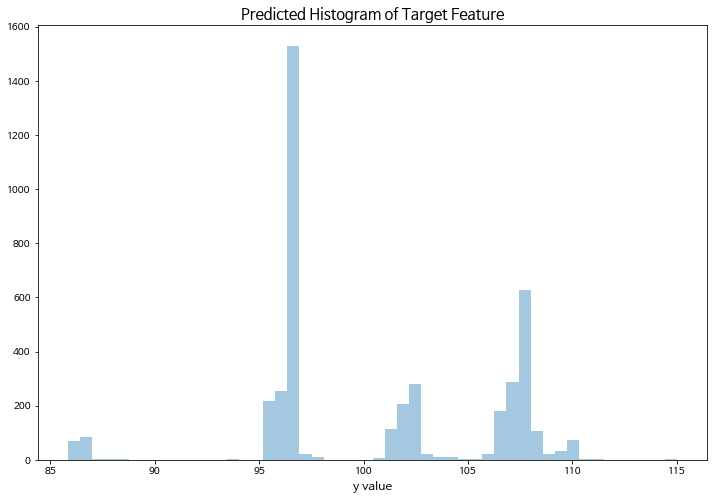

In [166]:
# 이상치 처리

ulimit = 115
predicted['y'].loc[predicted['y'] > ulimit] = ulimit

plt.figure(figsize=(12,8))
sns.distplot(predicted.y.values, bins=50, kde=False)
plt.xlabel('y value',fontsize=12)
plt.title('Predicted Histogram of Target Feature',fontsize=15)
plt.show()

### Feature Importances

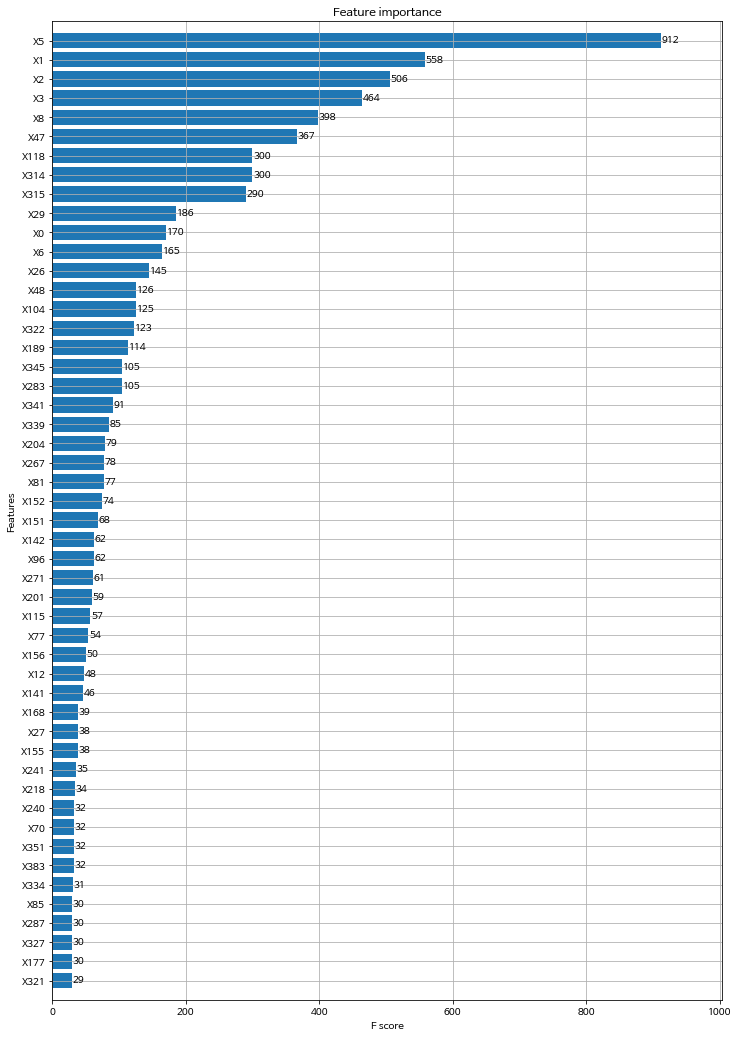

In [167]:
fig,ax = plt.subplots(figsize=(12,18))
xgb.plot_importance(model,max_num_features=50,height=0.8,ax=ax)
plt.show()